# Titanic, Machine Learning from Disaster

데이터 출처 : https://www.kaggle.com/c/titanic

The competition is simple : use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Using the patterns you find in the train.csv data, predict whether the other passengers on board (found in test.csv) survived.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 한글 폰트 설정
import os
os.name

import os
if os.name == 'posix' :
    plt.rc('font', family='AppleGothic')    # 맥
else:
    plt.rc('font', family='Malgun Gothic')  # 윈도우

# 마이너스 폰트 깨지는 문제애 대한 대처
plt.rc('axes', unicode_minus=False)

# 레티나 설정을 해주면 글씨가 더 선명해짐
%config InlineBackend.figure_font = 'retina'

# 1. 데이터셋 확인

In [8]:
# train 데이터 불러오기
df_train = pd.read_csv("train.csv")

print(df_train.shape)
df_train.head(2)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
## test 데이터 불러오기

# The test dataset contains similar information but does not disclose the “ground truth” for each passenger
# # It’s your job to predict these outcomes.
df_test = pd.read_csv("test.csv")

print(df_test.shape)
df_test.head(2)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [10]:
# 변수 정보
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


변수 정보
- Survived : 생존 여부 (0 = No, 1 = Yes)
- Pclass : Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)     
- Name : 이름
- Sex : 성별     
- Age : 나이   
- SibSp : 함께 탑승한 형제, 배우자 수     
- Parch : 함께 탑승한 부모, 자식 수
- Ticket : 티켓 번호     
- Fare : 탑승료
- Cabin : 객실 번호     
- Embarked : 탑승 항구 (C = Cherbourg, Q = Queenstown, S = Southampton)

In [12]:
# 수치 데이터 확인
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 1.1 결측치 확인

In [20]:
# df_train
df_train.isna().sum() / len(df_train) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [22]:
# df_test
df_test.isna().sum() / len(df_test) * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

Train, Test set에서 Age(약 20%), Cabin(약 80%), Embarked(약 0.22%, Train만) 칼럼이 NULL 데이터 존재

<Axes: >

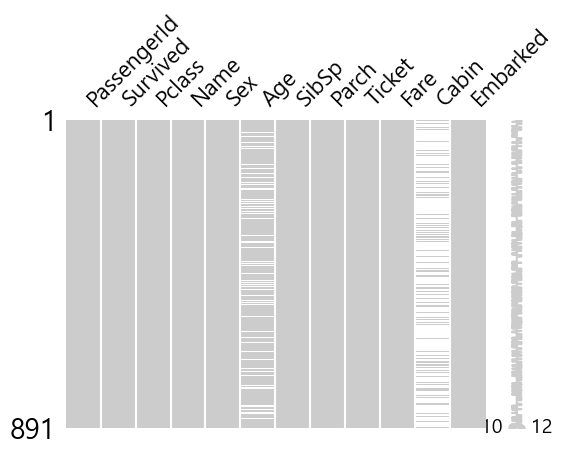

In [29]:
# 결측치 시각화 1
msno.matrix(df=df_train.iloc[:, :], figsize=(6, 4), color=(0.8, 0.8, 0.8))

<Axes: >

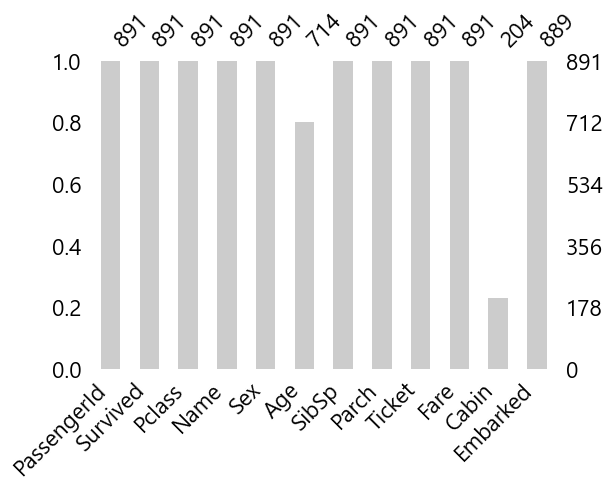

In [36]:
# 결측치 시각화 2
msno.bar(df=df_train.iloc[:, :], figsize=(6, 4), color=(0.8, 0.8, 0.8))

<Axes: >

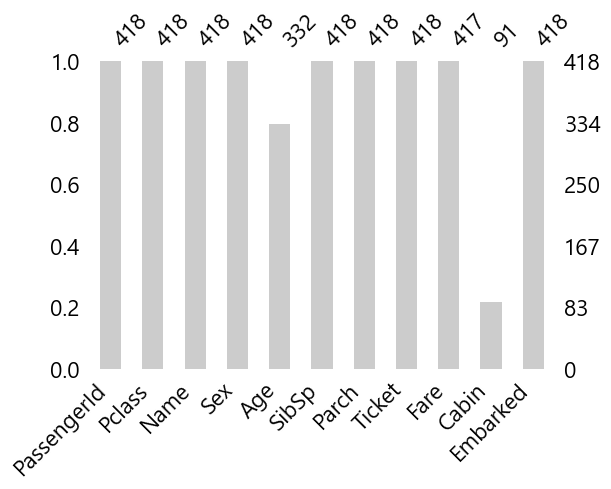

In [37]:
msno.bar(df=df_test.iloc[:, :], figsize=(6, 4), color=(0.8, 0.8, 0.8))

## 1.2 종속 변수 확인

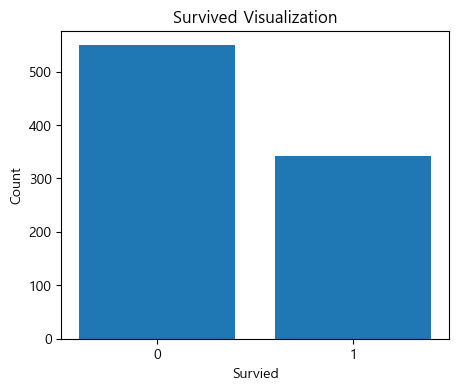

In [51]:
survive = df_train['Survived'].value_counts().sort_index()

# fig : 그래프의 빈 도면, 여기에 그래프의 모든 내용이 그려짐
# ax : 실제로 그래프와 plot을 그리는 데 사용되는 영역
fig, ax = plt.subplots(figsize=(5, 4))

ax.bar(survive.index, survive.values)
ax.set_xlabel('Survied')
ax.set_ylabel('Count')

ax.set_xticks([0, 1])

plt.title('Survived Visualization')
plt.show()

종속 변수의 분포가 균일한 편

# 2. EDA (Exploratory Data Analysis)

## 2.1 Pclass
- 카테고리이면서 순서가 있는 데이터

In [58]:
# Pclass 별 인원수
df_train[['Pclass', 'Survived']].groupby('Pclass').count()

,Survived
Pclass,
1,216
2,184
3,491


In [59]:
# Pclass 별 생존자
df_train[['Pclass', 'Survived']].groupby('Pclass').sum()

,Survived
Pclass,
1,136
2,87
3,119


In [72]:
## Pclass 별 사망자 vs 생존자

# margins=True : 행과 열의 합계를 추가
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='GnBu')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


<Axes: xlabel='Pclass'>

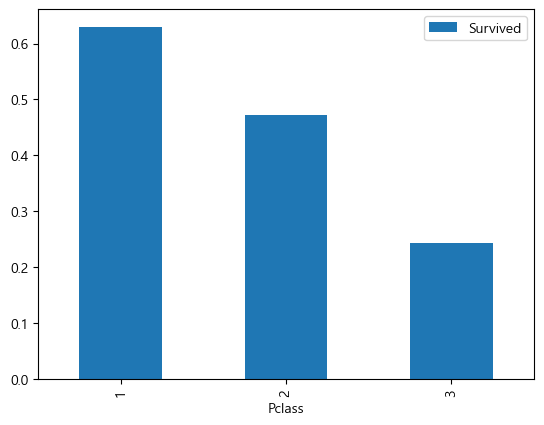

In [76]:
# Pclass 별 생존률
df_train[['Pclass', 'Survived']].groupby('Pclass').mean().plot.bar()

Text(0, 0.5, 'Count')

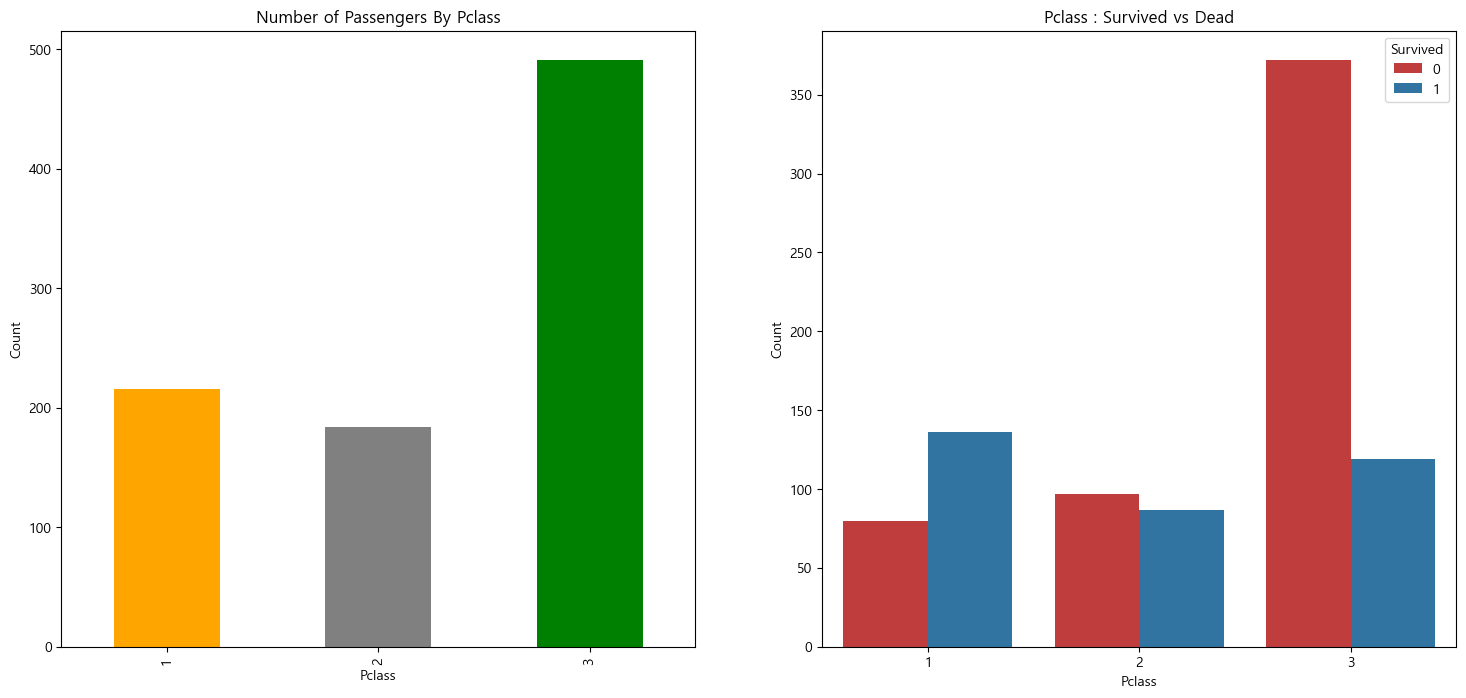

In [100]:
# 시각화

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Pclass'].value_counts().sort_index().plot.bar(color=['orange', 'gray', 'green'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot(data=df_train, x='Pclass', hue='Survived', palette=['#d62728', '#1f77b4'], ax=ax[1])
ax[1].set_title('Pclass : Survived vs Dead')
ax[1].set_ylabel('Count')

Pclass 정리
- Pclass가 좋을수록 생존률이 높음
- 생존률 : Pclass 1, 2, 3 순서대로 63%, 48%, 25%
- 생존에 Pclass가 큰 영향을 미친다고 생각할 수 있음 > 모델을 만들 때 Pclass 변수를 사용하는 것이 좋음

## 2.2 Sex

In [101]:
# Sex 별 생존률
df_train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [102]:
## Sex 별 사망자 vs 생존자
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='GnBu')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Text(0, 0.5, 'Count')

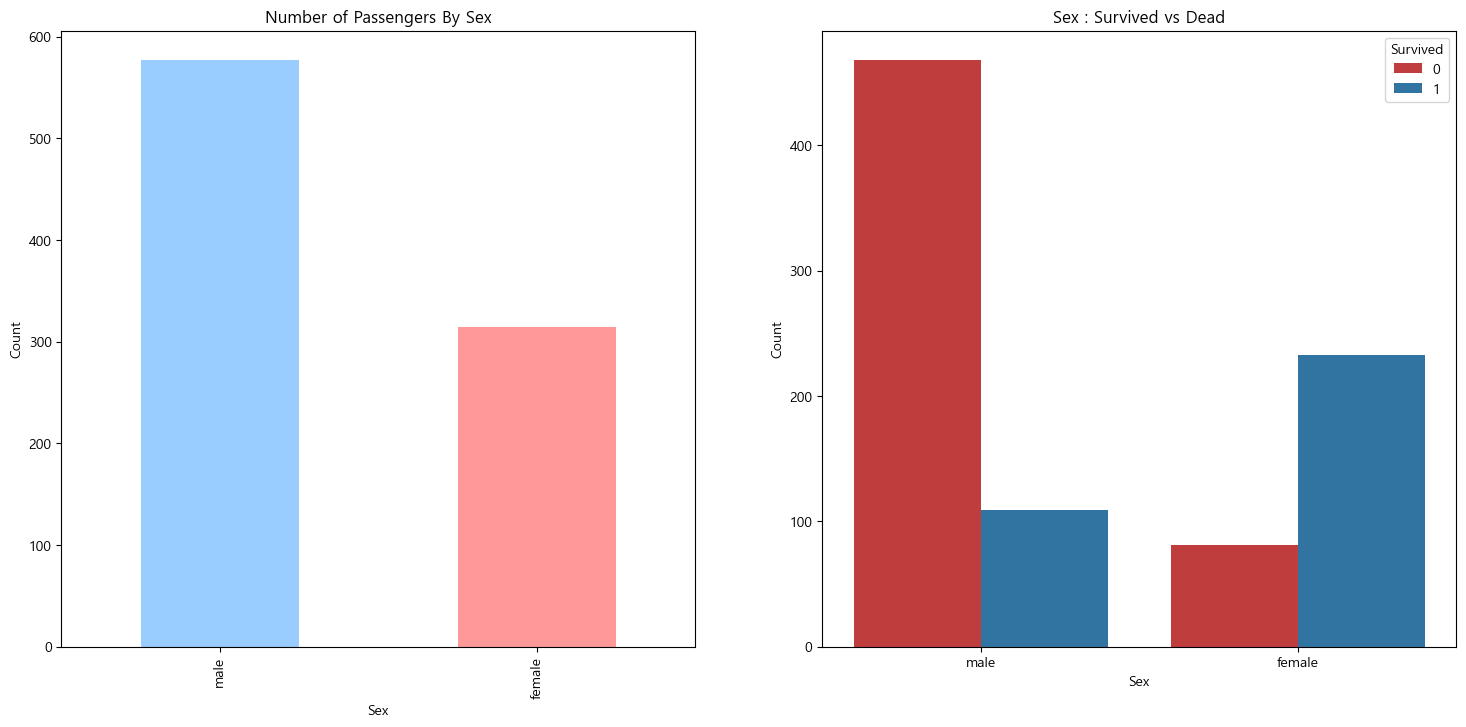

In [106]:
# 시각화

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Sex'].value_counts().sort_index(ascending=False).plot.bar(color=['#99ccff', '#ff9999'], ax=ax[0])
ax[0].set_title('Number of Passengers By Sex')
ax[0].set_ylabel('Count')

sns.countplot(data=df_train, x='Sex', hue='Survived', palette=['#d62728', '#1f77b4'], ax=ax[1])
ax[1].set_title('Sex : Survived vs Dead')
ax[1].set_ylabel('Count')

Sex 정리
- 여자가 생존할 확률이 높음
- 생존률 : male, female 순서대로 19%, 75%

## 2.3 Pclass & Sex

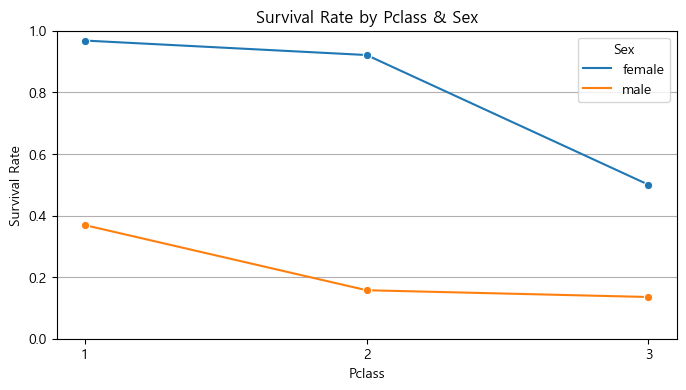

In [136]:
## 시각화

# 생존 비율 계산
survival_rate = df_train.groupby(['Pclass', 'Sex'])['Survived'].mean().reset_index()

plt.subplots(figsize=(8, 4))
sns.lineplot(data=survival_rate, x='Pclass', y='Survived', hue='Sex', marker='o')

plt.title('Survival Rate by Pclass & Sex')
plt.xlabel('Pclass')
plt.ylabel('Survival Rate')
plt.xticks([1, 2, 3])
plt.ylim(0, 1) # y축 범위 조정
plt.grid(axis='y')
plt.show()

Pclass & Sex 정리
- 모든 Pclass에서 female이 살 확률이 male보다 높음
- male, female에 상관없이 Pclass가 높을 수록 살 확률이 높음

## 2.4 Age

In [144]:
# 데이터 확인
print('제일 어린 탑승객 나이 : {:.1f} 살'.format(df_train['Age'].min()))
print('제일 나이 많은 탑승객 나이 : {:.1f} 살'.format(df_train['Age'].max()))
print('평균 탑승객 나이 : {:.1f} 살'.format(df_train['Age'].mean()))

제일 어린 탑승객 나이 : 0.4 살
제일 나이 많은 탑승객 나이 : 80.0 살
평균 탑승객 나이 : 29.7 살


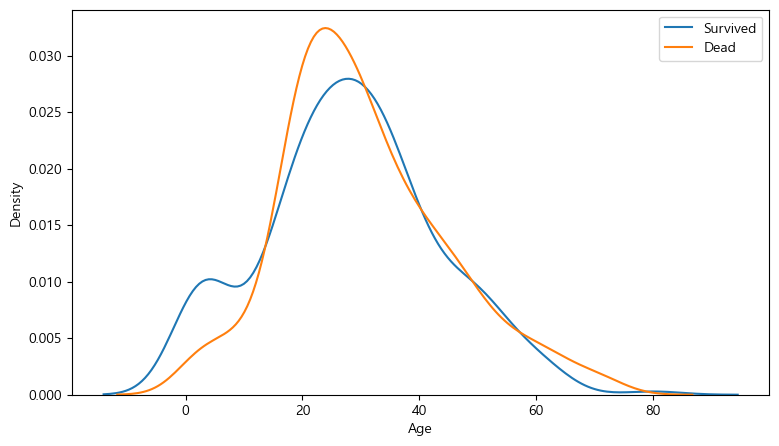

In [155]:
## 연령별 Survived vs Dead
fig, ax = plt.subplots(figsize=(9, 5))

# 커널 밀도 추정(Kernel Density Estimation)
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)

plt.legend(['Survived', 'Dead'])
plt.show()

Text(0.5, 1.0, 'Age Distribution by Pclass')

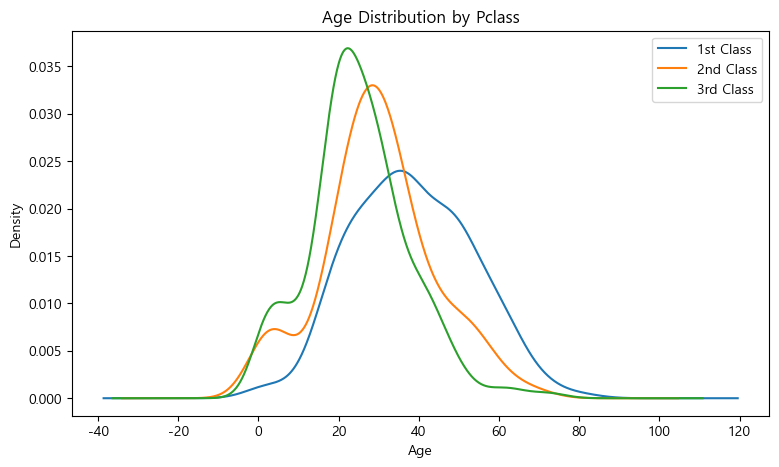

In [158]:
# Pclass별 연령대 시각화
fig, ax = plt.subplots(figsize=(9, 5))

df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.legend(['1st Class', '2nd Class', '3rd Class'])
plt.title('Age Distribution by Pclass')

In [ ]:
## Age 별 생존률

Age 정리
- 생존자 중 나이가 어린 경우가 많음
- Pclass가 높을 수록 나이 많은 사람의 비중이 커짐